Epoch 1/100
39/39 - 2s - loss: 0.1563 - 2s/epoch - 59ms/step
Epoch 2/100
39/39 - 1s - loss: 0.1007 - 677ms/epoch - 17ms/step
Epoch 3/100
39/39 - 1s - loss: 0.0513 - 647ms/epoch - 17ms/step
Epoch 4/100
39/39 - 1s - loss: 0.0476 - 664ms/epoch - 17ms/step
Epoch 5/100
39/39 - 1s - loss: 0.0508 - 648ms/epoch - 17ms/step
Epoch 6/100
39/39 - 1s - loss: 0.0509 - 685ms/epoch - 18ms/step
Epoch 7/100
39/39 - 1s - loss: 0.0511 - 753ms/epoch - 19ms/step
Epoch 8/100
39/39 - 1s - loss: 0.0459 - 707ms/epoch - 18ms/step
Epoch 9/100
39/39 - 1s - loss: 0.0486 - 765ms/epoch - 20ms/step
Epoch 10/100
39/39 - 1s - loss: 0.0461 - 746ms/epoch - 19ms/step
Epoch 11/100
39/39 - 1s - loss: 0.0475 - 764ms/epoch - 20ms/step
Epoch 12/100
39/39 - 1s - loss: 0.0426 - 678ms/epoch - 17ms/step
Epoch 13/100
39/39 - 1s - loss: 0.0385 - 710ms/epoch - 18ms/step
Epoch 14/100
39/39 - 1s - loss: 0.0443 - 710ms/epoch - 18ms/step
Epoch 15/100
39/39 - 1s - loss: 0.0479 - 710ms/epoch - 18ms/step
Epoch 16/100
39/39 - 1s - loss: 0.038

C:\Users\arjun\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


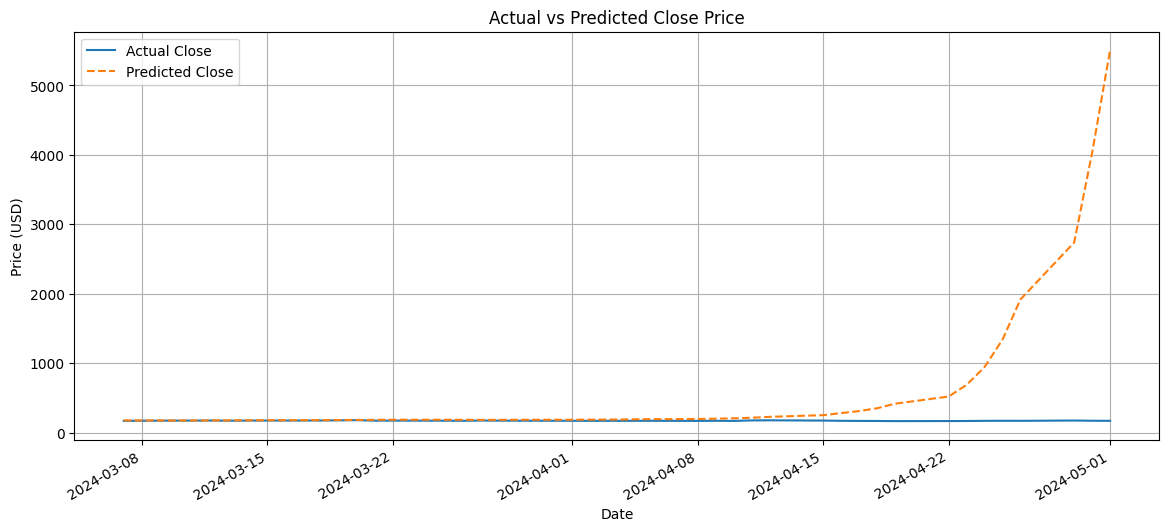

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Load and preprocess data
stock_data = pd.read_csv("./AAPL.csv", index_col='Date')
stock_data.index = pd.to_datetime(stock_data.index)

# Select features
features = ['Open', 'High', 'Low', 'Close']
X_feat = stock_data[features]

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_feat)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=stock_data.index)

# Define LSTM sequence creation
def lstm_split(data, n_steps):
    x, y = [], []
    for i in range(len(data) - n_steps):
        x.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps, -1])  # predict 'Close'
    return np.array(x), np.array(y)

# Change the time span here (past N days used for prediction)
n_steps = 60

# Prepare data
X1, y1 = lstm_split(X_scaled.values, n_steps)
split_idx = int(len(X1) * 0.8)
X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False, callbacks=[early_stop])

# Evaluate
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RMSE:", rmse)
print("MAPE:", mape)

# Inverse scale Close predictions
close_scaler = MinMaxScaler()
close_scaled = close_scaler.fit_transform(stock_data[['Close']])
y_test_real = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_real = close_scaler.inverse_transform(y_pred)

# Plot actual vs predicted Close price
plt.figure(figsize=(14, 6))
plt.plot(stock_data.index[-len(y_test):], y_test_real, label='Actual Close')
plt.plot(stock_data.index[-len(y_test):], y_pred_real, label='Predicted Close', linestyle='--')
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# === Predict future N days === #
future_steps = 10
future_predictions = []

# Get the last sequence from scaled data (n_steps, num_features)
last_sequence = X_scaled[-n_steps:]  # Should be shape (n_steps, num_features)

future_predictions = []

for _ in range(future_steps):
    input_seq = last_sequence.reshape(1, n_steps, X_scaled.shape[1])  # Ensure 3D shape
    pred_scaled = model.predict(input_seq, verbose=0)[0][0]
    future_predictions.append(pred_scaled)

    # Create the next input by appending predicted value and removing oldest
    next_input = np.append(last_sequence[1:], [[pred_scaled] * (X_scaled.shape[1] - 1) + [pred_scaled]], axis=0)
    last_sequence = next_input
# Inverse transform predictions
future_predictions_real = close_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare future dates
last_date = stock_data.index[-1]
future_dates = [last_date + dt.timedelta(days=i+1) for i in range(future_steps)]

# Plot future predictions
plt.figure(figsize=(14, 6))
plt.plot(stock_data.index[-60:], stock_data['Close'][-60:], label='Recent Close Prices')
plt.plot(future_dates, future_predictions_real, label='Future Predicted Close', linestyle='--', color='green')
plt.title("Next 10 Days Predicted Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()


In [ ]:
# Get the last sequence from scaled data (n_steps, num_features)
last_sequence = X_scaled[-n_steps:].values  # Convert to NumPy array

future_predictions = []

for _ in range(future_steps):
    input_seq = last_sequence.reshape(1, n_steps, X_scaled.shape[1])  # Ensure 3D shape
    pred_scaled = model.predict(input_seq, verbose=0)[0][0]
    future_predictions.append(pred_scaled)

    # Create the next input by appending predicted value and removing oldest
    next_input = np.append(last_sequence[1:], [[pred_scaled] * (X_scaled.shape[1] - 1) + [pred_scaled]], axis=0)
    last_sequence = next_input